<br>
<font size=8>Sentiment Analysis</font>
<br><br>
本篇文章主要用神经网络中三种最基本的神经网络dnn、rnn以及cnn构建情感分类模型，并比较和分析不同模型的优劣。具体而言本文分为四个部分:

- 数据处理
- DNN模型
- RNN模型
- CNN模型

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from collections import Counter
import tqdm

%matplotlib inline

In [2]:
tf.__version__

'1.6.0'

# 数据处理

## 数据加载

In [3]:
os.listdir("./data")

['glove.6B.300d.txt', '.DS_Store', 'neg.txt', 'pos.txt']

In [4]:
# 加载正负评论数据
# pos数据
with open("data/pos.txt", "r") as f:
    pos_text = f.read()

# neg数据
with open("data/neg.txt", "r") as f:
    neg_text = f.read()

## 描述性统计

In [5]:
# 积极文本统计
print("-" * 20 + " POSITIVE TEXT " + "-" * 20)
# 分句
pos_sentences = pos_text.lower().split("\n")
print("Total positive sentences: {}".format(len(pos_sentences)))
print("The average length of positive sentences: {}".format(np.mean([len(sentence.split()) for sentence in pos_sentences])))
print("The max length of positive sentences: {}".format(np.max([len(sentence.split()) for sentence in pos_sentences])))
print("The min length of positive sentences: {}".format(np.min([len(sentence.split()) for sentence in pos_sentences])))
# 统计高频词
c = Counter(pos_text.split()).most_common(100)
print("Most common words in positive sentences: \n{}".format(c))

# 校级文本统计
print()
print("-" * 20 + " NEGATIVE TEXT " + "-" * 20)
# 分句
neg_sentences = neg_text.lower().split("\n")
print("Total negative sentences: {}".format(len(neg_sentences)))
print("The average length of negative sentences: {}".format(np.mean([len(sentence.split()) for sentence in neg_sentences])))
print("The max length of negative sentences: {}".format(np.max([len(sentence.split()) for sentence in neg_sentences])))
print("The min length of negative sentences: {}".format(np.min([len(sentence.split()) for sentence in neg_sentences])))
# 统计高频词
c = Counter(neg_text.split()).most_common(100)
print("Most common words in negative sentences: \n{}".format(c))

-------------------- POSITIVE TEXT --------------------
Total positive sentences: 5331
The average length of positive sentences: 21.0921027949728
The max length of positive sentences: 59
The min length of positive sentences: 2
Most common words in positive sentences: 
[('.', 6972), (',', 5268), ('the', 5051), ('a', 3830), ('and', 3548), ('of', 3311), ('to', 1969), ('is', 1707), ('in', 1338), ('that', 1262), ('it', 1100), ('with', 883), ('as', 879), ('film', 822), ('but', 782), ('an', 754), ('its', 699), ('for', 673), ('this', 666), ("it's", 564), ('movie', 510), ('you', 494), ('on', 424), ('be', 419), ('by', 380), ('has', 379), ('not', 367), ('one', 366), ('at', 366), ('about', 363), ('from', 349), ('are', 348), ('his', 344), ('"', 330), ('--', 319), ('more', 311), ('all', 289), ('than', 282), ('like', 281), ('if', 264), ('have', 259), ('story', 256), ('who', 247), ('most', 240), ('what', 225), ('into', 213), ('so', 209), ('will', 199), ('good', 198), ('comedy', 192), ('or', 189), ('i'

## 数据预处理

- 构造词典Vocabulary
- 构造映射表
- 转换单词为tokens

In [6]:
# 句子最大长度
SENTENCE_LIMIT_SIZE = 20

### 构造词典

我们要基于整个语料来构造我们的词典，由于文本中包含许多干扰词汇，例如仅出现过1次的这类单词。对于这类极其低频词汇，我们可以对其进行去除，一方面能加快模型执行效率，一方面也能减少特殊词带来的噪声。

In [7]:
# 合并pos和neg文本
total_text = pos_text + "\n" + neg_text
# 统计词汇
c = Counter(total_text.split())

In [8]:
# 倒序查看词频
sorted(c.most_common(), key=lambda x: x[1])

[("century's", 1),
 ('jean-claud', 1),
 ('segal', 1),
 ('middle-earth', 1),
 ('too-tepid', 1),
 ('showed', 1),
 ('curls', 1),
 ('fed', 1),
 ('ponders', 1),
 ("it'", 1),
 ('enrapturing', 1),
 ('tempt', 1),
 ('inscrutable', 1),
 ('spiderman', 1),
 ('latent', 1),
 ('gangsta', 1),
 ('shook', 1),
 ('rattled', 1),
 ('deceptive', 1),
 ('grimness', 1),
 ('fatalist', 1),
 ('worldview', 1),
 ('lobbies', 1),
 ('two-lane', 1),
 ('roadside', 1),
 ('cafes', 1),
 ('permeate', 1),
 ('bona-fide', 1),
 ('outings', 1),
 ('cartoonlike', 1),
 ('magnet', 1),
 ('co-star', 1),
 ("'compleja", 1),
 ('intelectualmente', 1),
 ('retadora', 1),
 ('ladrón', 1),
 ('orquídeas', 1),
 ('esos', 1),
 ('filmes', 1),
 ('precisamente', 1),
 ('originalidad', 1),
 ('karmen', 1),
 ('chanting', 1),
 ('braided', 1),
 ('wipe', 1),
 ('jeweled', 1),
 ('beads', 1),
 ('lacerating', 1),
 ("'50's", 1),
 ('cheesiness', 1),
 ("johnson's", 1),
 ('orchestrates', 1),
 ('siberian', 1),
 ('sheep', 1),
 ('hosts', 1),
 ('parka-wrapped', 1),
 ('e

In [9]:
# 初始化两个token：pad和unk
vocab = ["<pad>", "<unk>"]

# 去除出现频次为1次的单词
for w, f in c.most_common():
    if f > 1:
        vocab.append(w)

In [10]:
print("The total size of our vocabulary is: {}".format(len(vocab)))

The total size of our vocabulary is: 10384


### 构造映射

In [11]:
# 单词到编码的映射，例如machine -> 10283
word_to_token = {word: token for token, word in enumerate(vocab)}
# 编码到单词的映射，例如10283 -> machine
token_to_word = {token: word for word, token in word_to_token.items()}

### 转换文本

In [12]:
def convert_text_to_token(sentence, word_to_token_map=word_to_token, limit_size=SENTENCE_LIMIT_SIZE):
    """
    根据单词-编码映射表将单个句子转化为token
    
    @param sentence: 句子，str类型
    @param word_to_token_map: 单词到编码的映射
    @param limit_size: 句子最大长度。超过该长度的句子进行截断，不足的句子进行pad补全
    
    return: 句子转换为token后的列表
    """
    # 获取unknown单词和pad的token
    unk_id = word_to_token_map["<unk>"]
    pad_id = word_to_token_map["<pad>"]
    
    # 对句子进行token转换，对于未在词典中出现过的词用unk的token填充
    tokens = [word_to_token_map.get(word, unk_id) for word in sentence.lower().split()]
    
    # Pad
    if len(tokens) < limit_size:
        tokens.extend([0] * (limit_size - len(tokens)))
    # Trunc
    else:
        tokens = tokens[:limit_size]
    
    return tokens

In [13]:
# 对pos文本处理
pos_tokens = []

for sentence in tqdm.tqdm(pos_sentences):
    tokens = convert_text_to_token(sentence)
    pos_tokens.append(tokens)

100%|██████████| 5331/5331 [00:00<00:00, 108848.83it/s]


In [14]:
# 对neg文本处理
neg_tokens = []

for sentence in tqdm.tqdm(neg_sentences):
    tokens = convert_text_to_token(sentence)
    neg_tokens.append(tokens)

100%|██████████| 5331/5331 [00:00<00:00, 103560.90it/s]


In [15]:
# 转化为numpy格式，方便处理
pos_tokens = np.array(pos_tokens)
neg_tokens = np.array(neg_tokens)

In [16]:
# 合并所有语料
total_tokens = np.concatenate((pos_tokens, neg_tokens), axis=0)

In [17]:
print("The shape of all tokens in our corpus: ({}, {})".format(*total_tokens.shape))

The shape of all tokens in our corpus: (10662, 20)


In [18]:
# 转化为numpy格式，方便处理
pos_targets = np.ones((pos_tokens.shape[0]))
neg_targets = np.zeros((neg_tokens.shape[0]))

In [19]:
# 合并所有target
total_targets = np.concatenate((pos_targets, neg_targets), axis=0).reshape(-1, 1)

In [20]:
print("The shape of all targets in our corpus: ({}, {})".format(*total_targets.shape))

The shape of all targets in our corpus: (10662, 1)


## 构造词向量

我们使用glove预训练好的词向量来做embedding:

- 如果当前词没有对应词向量，则用随机数产生的向量替代
- 如果当前词为< PAD >，则用0向量代替

### 加载glove预训练词向量

In [21]:
# 加载预训练好的glove词向量
with open("data/glove.6B.300d.txt", 'r') as f:
    words = set()
    word_to_vec = {}
    for line in f:
        line = line.strip().split()
        # 当前单词
        curr_word = line[0]
        words.add(curr_word)
        # 当前词向量
        word_to_vec[curr_word] = np.array(line[1:], dtype=np.float32)

In [22]:
print("The number of words which have pretrained-vectors in vocab is: {}".format(len(set(vocab)&set(words))))
print()
print("The number of words which do not have pretrained-vectors in vocab is : {}".format(len(set(vocab))-
                                                                                         len(set(vocab)&set(words))))

The number of words which have pretrained-vectors in vocab is: 9801

The number of words which do not have pretrained-vectors in vocab is : 583


### 构造词向量矩阵

In [23]:
VOCAB_SIZE = len(vocab)  # 10384
EMBEDDING_SIZE = 300

In [24]:
# 初始化词向量矩阵（这里命名为static是因为这个词向量矩阵用预训练好的填充，无需重新训练）
static_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])

for word, token in tqdm.tqdm(word_to_token.items()):
    # 用glove词向量填充，如果没有对应的词向量，则用随机数填充
    word_vector = word_to_vec.get(word, 0.2 * np.random.random(EMBEDDING_SIZE) - 0.1)
    static_embeddings[token, :] = word_vector

# 重置PAD为0向量
pad_id = word_to_token["<pad>"]
static_embeddings[pad_id, :] = np.zeros(EMBEDDING_SIZE)

100%|██████████| 10384/10384 [00:00<00:00, 61619.85it/s]


In [25]:
static_embeddings = static_embeddings.astype(np.float32)

## 辅助函数

### 分割train和test

In [26]:
def split_train_test(x, y, train_ratio=0.8, shuffle=True):
    """
    分割train和test
    
    @param x: 输入特征
    @param y: 目标
    @param train_ratio: 训练样本比例
    @param shuffle: 是否shuffle
    """
    assert x.shape[0] == y.shape[0],  print("error shape!")
    
    if shuffle:
        # shuffle
        shuffled_index = np.random.permutation(range(x.shape[0]))
        x = x[shuffled_index]
        y = y[shuffled_index]
    
    # 分离train和test
    train_size = int(x.shape[0] * train_ratio)
    x_train = x[:train_size]
    x_test = x[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    return x_train, x_test, y_train, y_test

In [27]:
# 划分train和test
x_train, x_test, y_train, y_test = split_train_test(total_tokens, total_targets)

### get_batch函数

In [29]:
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))

        x = x[shuffled_index]
        y = y[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
    
        yield x_batch, y_batch

# DNN模型

## 构建模型图

<img src="images/dnn.png" style="width:500;height:500px;">

In [30]:
# 清空图
tf.reset_default_graph()

In [31]:
# 定义神经网络超参数
HIDDEN_SIZE = 512
LEARNING_RATE = 0.001
EPOCHES = 50
BATCH_SIZE = 256

In [32]:
with tf.name_scope("dnn"):
    # 输入及输出tensor
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    
    # embeddings
    with tf.name_scope("embeddings"):
        # 用pre-trained词向量来作为embedding层
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 相加词向量得到句子向量
        sum_embed = tf.reduce_sum(embed, axis=1, name="sum_embed")
        
    # model
    with tf.name_scope("model"):
        # 隐层权重
        W1 = tf.Variable(tf.random_normal(shape=(EMBEDDING_SIZE, HIDDEN_SIZE), stddev=0.1), name="W1")
        b1 = tf.Variable(tf.zeros(shape=(HIDDEN_SIZE), name="b1"))
        
        # 输出层权重
        W2 = tf.Variable(tf.random_normal(shape=(HIDDEN_SIZE, 1), stddev=0.1), name="W2")
        b2 = tf.Variable(tf.zeros(shape=(1), name="b2"))
        
        # 结果
        z1 = tf.add(tf.matmul(sum_embed, W1), b1)
        a1 = tf.nn.relu(z1)
        
        logits = tf.add(tf.matmul(a1, W2), b2)
        outputs = tf.nn.sigmoid(logits, name="outputs")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(outputs, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [33]:
# 存储准确率
dnn_train_accuracy = []
dnn_test_accuracy = []

In [34]:
saver = tf.train.Saver()

In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/dnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, batch_loss = sess.run([optimizer, loss],
                                     feed_dict={inputs: x_batch, targets: y_batch})
            
            total_loss += batch_loss
        
        # 在train上准确率
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        dnn_train_accuracy.append(train_acc)
        
        # 在test上准确率
        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        dnn_test_accuracy.append(test_acc)
        
        print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    test_acc))
    # 存储模型
    saver.save(sess, "./checkpoints/dnn")
    writer.close()

Epoch: 1, Train loss: 0.9776, Train accuracy: 0.7222, Test accuracy: 0.7089
Epoch: 2, Train loss: 0.6184, Train accuracy: 0.7553, Test accuracy: 0.7126
Epoch: 3, Train loss: 0.5681, Train accuracy: 0.7673, Test accuracy: 0.7164
Epoch: 4, Train loss: 0.4983, Train accuracy: 0.7909, Test accuracy: 0.7295
Epoch: 5, Train loss: 0.4666, Train accuracy: 0.7931, Test accuracy: 0.6981
Epoch: 6, Train loss: 0.4239, Train accuracy: 0.8216, Test accuracy: 0.7140
Epoch: 7, Train loss: 0.4829, Train accuracy: 0.7902, Test accuracy: 0.6915
Epoch: 8, Train loss: 0.4098, Train accuracy: 0.8443, Test accuracy: 0.7182
Epoch: 9, Train loss: 0.3423, Train accuracy: 0.8778, Test accuracy: 0.7215
Epoch: 10, Train loss: 0.3247, Train accuracy: 0.8606, Test accuracy: 0.7028
Epoch: 11, Train loss: 0.2852, Train accuracy: 0.9185, Test accuracy: 0.7173
Epoch: 12, Train loss: 0.2792, Train accuracy: 0.9264, Test accuracy: 0.7276
Epoch: 13, Train loss: 0.2285, Train accuracy: 0.9323, Test accuracy: 0.7243
Epoch: 1

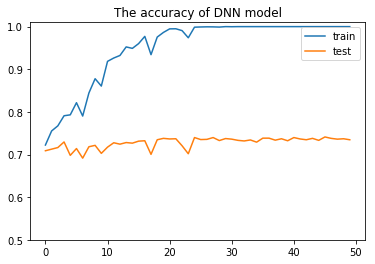

In [47]:
plt.plot(dnn_train_accuracy)
plt.plot(dnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of DNN model")
plt.legend(["train", "test"])

## 预测模型

In [48]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/dnn")
    
    total_correct = 0
    acc = sess.run(accuracy,
                    feed_dict={inputs: x_test, 
                                targets: y_test})
    total_correct += acc
    print("The DNN model accuracy on test set: {:.2f}%".format(100* total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/dnn
The DNN model accuracy on test set: 73.46%


在命令行执行tensorboard --logdir="./graphs/dnn" --port 6006可以看到模型的tensorboard

<img src="images/dnn-tensorboard.png" style="width:500;height:500px;">

# RNN模型

## 构建模型图

In [60]:
# 清空图
tf.reset_default_graph()

In [59]:
# 定义网络超参数
HIDDEN_SIZE = 512
LEARNING_RATE = 0.001
KEEP_PROB = 0.5
EPOCHES = 50
BATCH_SIZE = 256

In [61]:
with tf.name_scope("rnn"):
    # placeholders
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 20), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
    
    # model
    with tf.name_scope("model"):
        # 构造lstm单元
        lstm = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
        # 添加dropout
        drop_lstm = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=KEEP_PROB)
        _, lstm_state = tf.nn.dynamic_rnn(drop_lstm, embed, dtype=tf.float32)
        
        # 输出层权重
        W = tf.Variable(tf.truncated_normal((HIDDEN_SIZE, 1), mean=0.0, stddev=0.1), name="W")
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(lstm_state.h, W), b)
        outputs = tf.nn.sigmoid(logits, name="outputs")
        
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(outputs, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [62]:
# 存储准确率
rnn_train_accuracy = []
rnn_test_accuracy = []

In [63]:
saver = tf.train.Saver()

In [64]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/rnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        rnn_train_accuracy.append(train_acc)

        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        rnn_test_accuracy.append(test_acc)

        
        print("Training epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                             total_loss / n_batches,
                                                                                                             train_acc,
                                                                                                             test_acc))
    
    saver.save(sess, "checkpoints/rnn")
    writer.close()

Training epoch: 1, Train loss: 1.2306, Train accuracy: 0.7559, Test accuracy: 0.7318
Training epoch: 2, Train loss: 0.9780, Train accuracy: 0.7838, Test accuracy: 0.7309
Training epoch: 3, Train loss: 0.9003, Train accuracy: 0.8061, Test accuracy: 0.7314
Training epoch: 4, Train loss: 0.8172, Train accuracy: 0.8483, Test accuracy: 0.7417
Training epoch: 5, Train loss: 0.7124, Train accuracy: 0.8801, Test accuracy: 0.7407
Training epoch: 6, Train loss: 0.5750, Train accuracy: 0.8792, Test accuracy: 0.7159
Training epoch: 7, Train loss: 0.5087, Train accuracy: 0.9417, Test accuracy: 0.7290
Training epoch: 8, Train loss: 0.3743, Train accuracy: 0.9546, Test accuracy: 0.7267
Training epoch: 9, Train loss: 0.2559, Train accuracy: 0.9730, Test accuracy: 0.7346
Training epoch: 10, Train loss: 0.1711, Train accuracy: 0.9757, Test accuracy: 0.7239
Training epoch: 11, Train loss: 0.1832, Train accuracy: 0.9811, Test accuracy: 0.7243
Training epoch: 12, Train loss: 0.1170, Train accuracy: 0.9852,

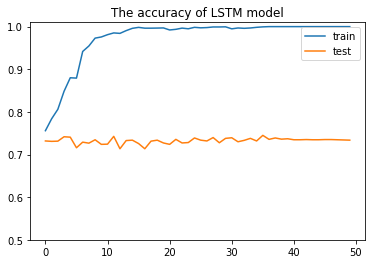

In [66]:
plt.plot(rnn_train_accuracy)
plt.plot(rnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of LSTM model")
plt.legend(["train", "test"])

## 预测模型

In [67]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/rnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100* total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/rnn
The LSTM model accuracy on test set: 73.37%


在命令行执行tensorboard --logdir="./graphs/rnn" --port 6006可以看到模型的tensorboard

<img src="images/lstm-tensorboard.png" style="width:500;height:500px;">

# CNN模型

In [69]:
# 清空图
tf.reset_default_graph()

In [70]:
# 我在这里定义了5种filter，每种100个
filters_size = [2, 3, 4, 5, 6]
num_filters = 100
# 超参数
BATCH_SIZE = 256
EPOCHES = 50
LEARNING_RATE = 0.001
L2_LAMBDA = 10
KEEP_PROB = 0.8

## 构建模型图

In [71]:
with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 20), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
    
    # 用来存储max-pooling的结果
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            pooled_outputs.append(max_pooling)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, KEEP_PROB)
    
    # output
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(predictions, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [72]:
# 存储准确率
cnn_train_accuracy = []
cnn_test_accuracy = []

In [73]:
saver = tf.train.Saver()

In [74]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        cnn_train_accuracy.append(train_acc)
        
        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        cnn_test_accuracy.append(test_acc)
        
        print("Training epoch: {}, Training loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                                total_loss / n_batches,
                                                                                                                train_acc,
                                                                                                               test_acc))
    
    saver.save(sess, "checkpoints/cnn")
    writer.close()

Training epoch: 1, Training loss: 9.8113, Train accuracy: 0.7357, Test accuracy: 0.6714
Training epoch: 2, Training loss: 2.0410, Train accuracy: 0.7422, Test accuracy: 0.6934
Training epoch: 3, Training loss: 1.3115, Train accuracy: 0.7473, Test accuracy: 0.7145
Training epoch: 4, Training loss: 1.2251, Train accuracy: 0.7541, Test accuracy: 0.7267
Training epoch: 5, Training loss: 1.1713, Train accuracy: 0.7769, Test accuracy: 0.7365
Training epoch: 6, Training loss: 1.1336, Train accuracy: 0.7769, Test accuracy: 0.7304
Training epoch: 7, Training loss: 1.0963, Train accuracy: 0.7822, Test accuracy: 0.7375
Training epoch: 8, Training loss: 1.0792, Train accuracy: 0.7958, Test accuracy: 0.7346
Training epoch: 9, Training loss: 1.0572, Train accuracy: 0.7959, Test accuracy: 0.7393
Training epoch: 10, Training loss: 1.0346, Train accuracy: 0.8023, Test accuracy: 0.7412
Training epoch: 11, Training loss: 1.0174, Train accuracy: 0.8105, Test accuracy: 0.7403
Training epoch: 12, Training l

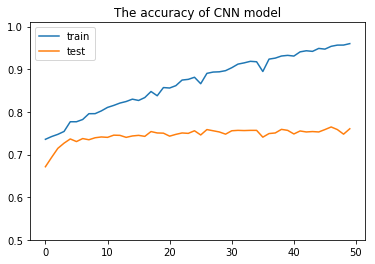

In [76]:
plt.plot(cnn_train_accuracy)
plt.plot(cnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "test"])

## 预测模型

In [75]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/cnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100 * total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/cnn
The LSTM model accuracy on test set: 75.25%


在命令行执行tensorboard --logdir="./graphs/rnn" --port 6006可以看到模型的tensorboard

<img src="images/cnn-tensorboard.png" style="width:500;height:500px;">

# CNN multi-channel

## 构建模型图

In [123]:
# 清空图
tf.reset_default_graph()

In [124]:
# 我在这里定义了5种filter，每种100个
filters_size = [2, 3, 4, 5, 6]
num_filters = 100
# 超参数
BATCH_SIZE = 256
EPOCHES = 8
LEARNING_RATE = 0.001
L2_LAMBDA = 10
KEEP_PROB = 0.8

In [125]:
with tf.name_scope("cnn_multichannels"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 20), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    # embeddings
    with tf.name_scope("embeddings"):
        # static embeddings
        static_embedding_matrix = tf.Variable(initial_value=static_embeddings, 
                                              trainable=False, 
                                              name="static_embedding_matrix")
        static_embed = tf.nn.embedding_lookup(static_embedding_matrix, inputs, name="static_embed")
        static_embed_expanded = tf.expand_dims(static_embed, -1, name="static_embed_expand")
        
        # non-static embeddings
        dynamic_embedding_matrix = tf.Variable(tf.random_normal(shape=(VOCAB_SIZE, EMBEDDING_SIZE), stddev=0.1), 
                                               trainable=True, 
                                               name="dynamic_embedding_matrix")
        dynamic_embed = tf.nn.embedding_lookup(dynamic_embedding_matrix, inputs, name="dynamic_embed")
        dynamic_embed_expanded = tf.expand_dims(dynamic_embed, -1, name="dynamic_embed_expand")
        
        # stack
        embed_expanded = tf.concat((static_embed_expanded, dynamic_embed_expanded), axis=-1, name="embed_expanded")
    
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            # 注意这里filter的channel要指定为2
            filter_shape = [filter_size, EMBEDDING_SIZE, 2, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                   padding="VALID",
                                   name="max_pooling")
            pooled_outputs.append(max_pooling)
        
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, KEEP_PROB)
    
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(predictions, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [126]:
multi_cnn_train_accuracy = []
multi_cnn_test_accuracy = []

In [127]:
saver = tf.train.Saver()

In [128]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/multi_cnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        multi_cnn_train_accuracy.append(train_acc)
        
        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        multi_cnn_test_accuracy.append(test_acc)
        
        print("Training epoch: {}, Training loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                                total_loss / n_batches,
                                                                                                                train_acc,
                                                                                                                test_acc))
    
    saver.save(sess, "checkpoints/multi_cnn")
    writer.close()

Training epoch: 1, Training loss: 11.0021, Train accuracy: 0.7970, Test accuracy: 0.6948
Training epoch: 2, Training loss: 2.1337, Train accuracy: 0.8079, Test accuracy: 0.6943
Training epoch: 3, Training loss: 1.2810, Train accuracy: 0.8131, Test accuracy: 0.7304
Training epoch: 4, Training loss: 1.1661, Train accuracy: 0.8056, Test accuracy: 0.7271
Training epoch: 5, Training loss: 1.0673, Train accuracy: 0.8533, Test accuracy: 0.7548
Training epoch: 6, Training loss: 0.9538, Train accuracy: 0.8877, Test accuracy: 0.7628
Training epoch: 7, Training loss: 0.8294, Train accuracy: 0.9218, Test accuracy: 0.7703
Training epoch: 8, Training loss: 0.7052, Train accuracy: 0.9447, Test accuracy: 0.7703


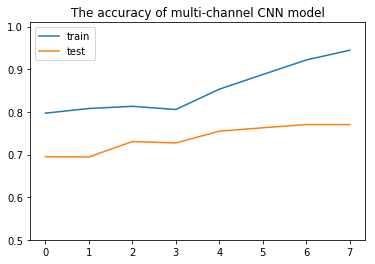

In [131]:
plt.plot(multi_cnn_train_accuracy)
plt.plot(multi_cnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of multi-channel CNN model")
plt.legend(["train", "test"])

## 预测模型

In [132]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/multi_cnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100 * total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/multi_cnn
The LSTM model accuracy on test set: 76.93%
